In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### A random walk with drift

The model is:

$$
y_0 = \beta_0 \ \ \text{ and } \ \ y_{t+1} = y_{t} + \beta_1 + \epsilon_t
$$


where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$ is guassian white noise error term.

This is similar to the linear model, but the data generating process is different.  The MLE estimates of the parameters are

$$
\begin{align*}
\hat{\beta}_1 &= \frac{1}{n}\sum_{i=1}^n (y_i - y_{i-1}) = \frac{1}{n} (y_n - y_0)\\
\hat{\beta}_0 &= y_0\\
\hat{\sigma}^2 &= \frac{1}{n}\sum_{i=1}^n (y_i - y_{i-1} - \hat{\beta}_1)^2
\end{align*}
$$

### Drift forecast

This leads to a **drift forecast** where we predict $y_t = y_n + \beta_1 (t-n)$ for $t > n$.

In [5]:
df = pd.read_csv("data_new.csv")

In [8]:
df = df.drop(labels="Unnamed: 0", axis=1)

In [11]:
df = df[['Age (Kyr ago)', 'CO2 (ppmv) ', 'Rescaled MST (°C)', 'δ18O ', 'GLT_syn', 'd18O_benthic', 'BIT index ']]

In [14]:
df

,Age (Kyr ago),CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index
0,-0.04,350.85,23.43,-9.50,-35.79,3.23,0.51
1,0.08,286.50,23.38,-9.33,-35.79,3.23,0.65
2,0.14,284.01,22.91,-9.35,-35.79,3.23,0.48
3,0.31,276.72,23.31,-9.52,-35.79,3.23,0.61
4,0.41,283.73,23.80,-9.12,-35.79,3.23,0.59
...,...,...,...,...,...,...,...
368,73.91,232.26,23.65,-8.71,-36.52,4.05,0.99
369,74.13,231.60,23.28,-9.02,-37.39,4.02,0.99
370,74.28,233.24,23.30,-9.33,-38.15,4.01,0.93
371,74.50,240.40,22.77,-9.25,-39.55,3.99,0.91


In [18]:
np.array(df["Age (Kyr ago)"])

array([-4.000e-02,  8.000e-02,  1.400e-01,  3.100e-01,  4.100e-01,
        5.600e-01,  6.600e-01,  8.100e-01,  1.000e+00,  1.150e+00,
        1.310e+00,  1.460e+00,  1.630e+00,  1.850e+00,  2.050e+00,
        2.230e+00,  2.370e+00,  2.510e+00,  2.640e+00,  2.770e+00,
        2.930e+00,  3.100e+00,  3.270e+00,  3.490e+00,  3.690e+00,
        3.840e+00,  4.020e+00,  4.290e+00,  4.380e+00,  4.600e+00,
        4.740e+00,  4.870e+00,  5.030e+00,  5.190e+00,  5.370e+00,
        5.540e+00,  5.710e+00,  5.850e+00,  6.030e+00,  6.190e+00,
        6.370e+00,  6.580e+00,  6.780e+00,  6.960e+00,  7.210e+00,
        7.390e+00,  7.550e+00,  7.720e+00,  8.380e+00,  8.900e+00,
        9.440e+00,  9.730e+00,  1.002e+01,  1.023e+01,  1.036e+01,
        1.053e+01,  1.071e+01,  1.089e+01,  1.107e+01,  1.123e+01,
        1.139e+01,  1.165e+01,  1.189e+01,  1.208e+01,  1.230e+01,
        1.251e+01,  1.270e+01,  1.289e+01,  1.312e+01,  1.336e+01,
        1.357e+01,  1.387e+01,  1.411e+01,  1.435e+01,  1.462e

In [20]:
df_reverse = df[df.columns[1:]][::-1]

In [23]:
df_reverse["Age (Kyr ago)"] = np.array(df["Age (Kyr ago)"])

In [26]:
df_reverse.columns

Index(['CO2 (ppmv) ', 'Rescaled MST (°C)', 'δ18O ', 'GLT_syn', 'd18O_benthic',
       'BIT index ', 'Age (Kyr ago)'],
      dtype='object')

In [32]:
df_reverse['log_RescaledMST'] = np.log10(df_reverse['Rescaled MST (°C)'])
MST_train = df_reverse.iloc[:-20].copy()
MST_test = df_reverse.iloc[-20:].copy()

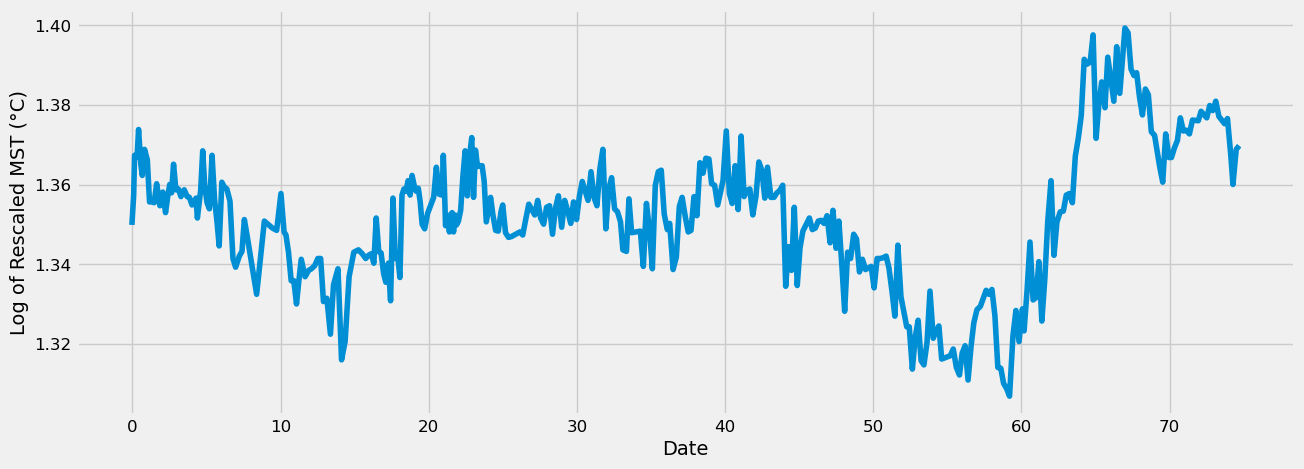

In [35]:
plt.figure(figsize=(14,5))

plt.plot(df_reverse["Age (Kyr ago)"], df_reverse["log_RescaledMST"])

plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of Rescaled MST (°C)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gcf().autofmt_xdate()


plt.show()

In [39]:
beta_hat = (MST_train.log_RescaledMST.values[-1] - MST_train.log_RescaledMST.values[0])/len(MST_train)
drift_pred = MST_train.log_RescaledMST.values[-1] + beta_hat*np.arange(1,len(MST_test) + 1)
sigma = np.sqrt(((MST_train.log_RescaledMST.diff() - beta_hat)**2).sum()/len(MST_train))

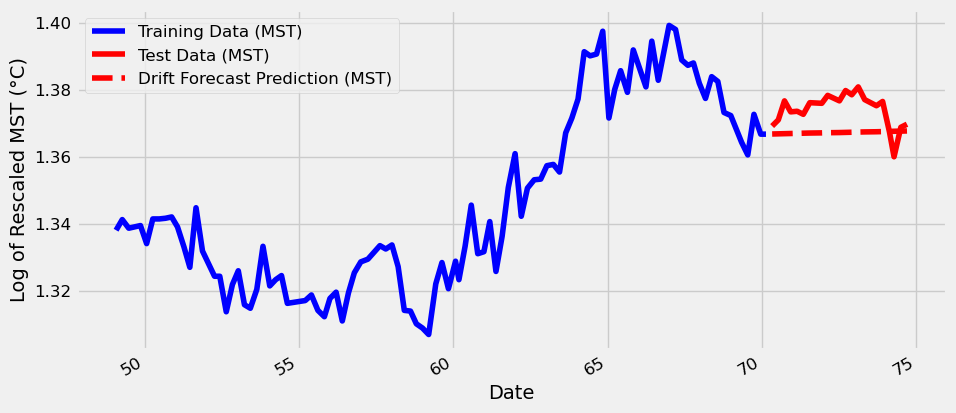

In [42]:
plt.figure(figsize=(10,5))

plt.plot(MST_train["Age (Kyr ago)"][-100:],
            MST_train.log_RescaledMST[-100:],
            'b-',
            label="Training Data (MST)")

plt.plot(MST_test["Age (Kyr ago)"],
            MST_test.log_RescaledMST,
            'r-',
            label="Test Data (MST)")

plt.plot(MST_test["Age (Kyr ago)"],
            drift_pred,
            'r--',
            label="Drift Forecast Prediction (MST)")

plt.legend(fontsize=12, loc=2)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of Rescaled MST (°C)", fontsize=14)

plt.gcf().autofmt_xdate()


plt.show()

plt.show()

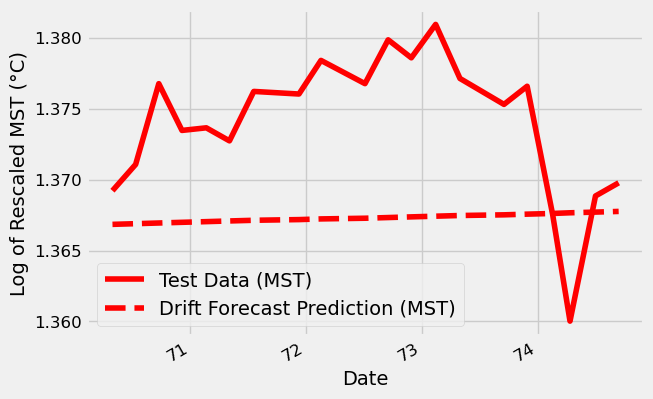

In [45]:
plt.plot(MST_test["Age (Kyr ago)"],
            MST_test.log_RescaledMST,
            'r-',
            label="Test Data (MST)")
plt.plot(MST_test["Age (Kyr ago)"],
            drift_pred,
            'r--',
            label="Drift Forecast Prediction (MST)")

# plt.legend(fontsize=12, loc=2)
plt.legend()
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of Rescaled MST (°C)", fontsize=14)

plt.gcf().autofmt_xdate()
plt.show()

In [55]:
df_reverse.columns[2:-2]

Index(['δ18O ', 'GLT_syn', 'd18O_benthic', 'BIT index '], dtype='object')

In [57]:
for col in df_reverse.columns[2:-2]:
    col_=f"log_{col}"
    print(col_)

log_δ18O 
log_GLT_syn
log_d18O_benthic
log_BIT index 


In [59]:
for col in df_reverse.columns[2:-2]:
    col_=f"log_{col}"
    df_reverse[col_] = np.log10(df_reverse[col])


In [101]:
df_reverse["log_GLT_syn"] = np.log10(abs(df_reverse["GLT_syn"]))

In [119]:
df_reverse["log_δ18O "] = np.log10(abs(df_reverse["δ18O "]))

In [147]:
df_reverse["log_CO2 (ppmv)"] = np.log10(abs(df_reverse["CO2 (ppmv) "]))

In [149]:
df_reverse.columns

Index(['CO2 (ppmv) ', 'Rescaled MST (°C)', 'δ18O ', 'GLT_syn', 'd18O_benthic',
       'BIT index ', 'Age (Kyr ago)', 'log_RescaledMST', 'log_δ18O ',
       'log_GLT_syn', 'log_d18O_benthic', 'log_BIT index ', 'log_CO2 (ppmv)'],
      dtype='object')

In [151]:
X_train = df_reverse.iloc[:-20].copy()
Y_test = df_reverse.iloc[-20:].copy()

In [153]:
beta_hat = (X_train.log_d18O_benthic.values[-1] - X_train.log_d18O_benthic.values[0])/len(X_train)
drift_pred = X_train.log_d18O_benthic.values[-1] + beta_hat*np.arange(1,len(Y_test) + 1)
sigma = np.sqrt(((X_train.log_RescaledMST.diff() - beta_hat)**2).sum()/len(X_train))

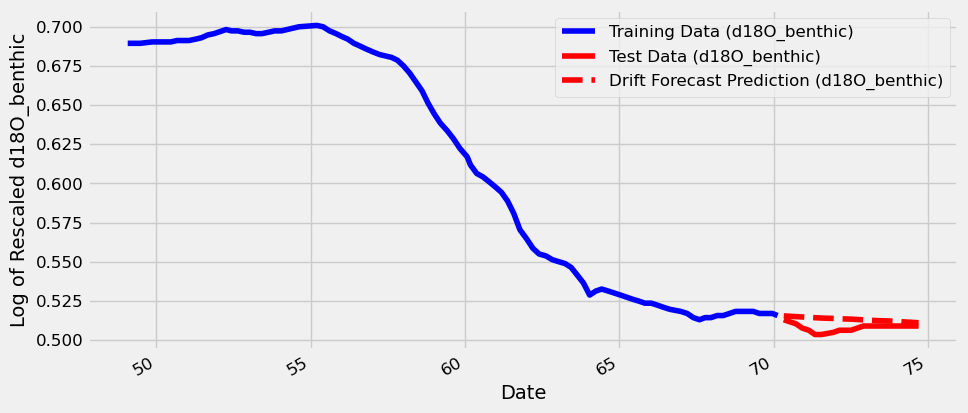

In [155]:
plt.figure(figsize=(10,5))


plt.plot(X_train["Age (Kyr ago)"][-100:],
            X_train.log_d18O_benthic[-100:],
            'b-',
            label="Training Data (d18O_benthic)")

plt.plot(Y_test["Age (Kyr ago)"],
            Y_test.log_d18O_benthic,
            'r-',
            label="Test Data (d18O_benthic)")

plt.plot(Y_test["Age (Kyr ago)"],
            drift_pred,
            'r--',
            label="Drift Forecast Prediction (d18O_benthic)")

plt.legend(fontsize=12, loc=2)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of Rescaled d18O_benthic", fontsize=14)

plt.gcf().autofmt_xdate()
plt.legend(fontsize=12, loc=1)

plt.show()

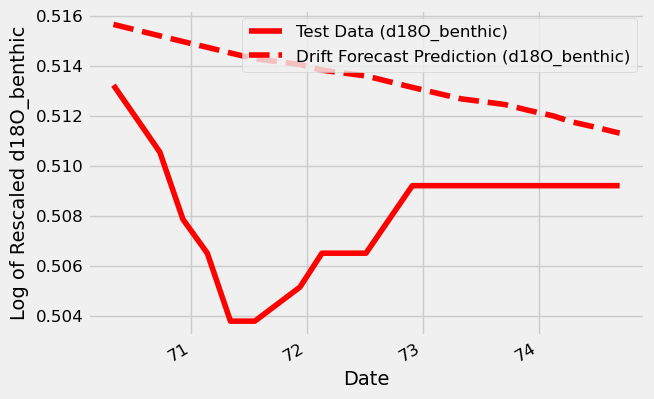

In [157]:
plt.plot(Y_test["Age (Kyr ago)"],
            Y_test.log_d18O_benthic,
            'r-',
            label="Test Data (d18O_benthic)")

plt.plot(Y_test["Age (Kyr ago)"],
            drift_pred,
            'r--',
            label="Drift Forecast Prediction (d18O_benthic)")

plt.legend(fontsize=12, loc=2)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of Rescaled d18O_benthic", fontsize=14)

plt.gcf().autofmt_xdate()
plt.legend(fontsize=12, loc=1)

plt.show()

In [159]:
df_reverse.columns

Index(['CO2 (ppmv) ', 'Rescaled MST (°C)', 'δ18O ', 'GLT_syn', 'd18O_benthic',
       'BIT index ', 'Age (Kyr ago)', 'log_RescaledMST', 'log_δ18O ',
       'log_GLT_syn', 'log_d18O_benthic', 'log_BIT index ', 'log_CO2 (ppmv)'],
      dtype='object')

In [161]:
beta_hat = (X_train.log_GLT_syn.values[-1] - X_train.log_GLT_syn.values[0])/len(X_train)
drift_pred = X_train.log_GLT_syn.values[-1] + beta_hat*np.arange(1,len(Y_test) + 1)
sigma = np.sqrt(((X_train.log_GLT_syn.diff() - beta_hat)**2).sum()/len(X_train))

In [163]:
df_reverse

,CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index,Age (Kyr ago),log_RescaledMST,log_δ18O,log_GLT_syn,log_d18O_benthic,log_BIT index,log_CO2 (ppmv)
372,241.89,22.38,-9.20,-41.10,3.95,0.87,-0.04,1.349860,0.963788,1.613842,0.596597,-0.060481,2.383618
371,240.40,22.77,-9.25,-39.55,3.99,0.91,0.08,1.357363,0.966142,1.597146,0.600973,-0.040959,2.380934
370,233.24,23.30,-9.33,-38.15,4.01,0.93,0.14,1.367356,0.969882,1.581495,0.603144,-0.031517,2.367803
369,231.60,23.28,-9.02,-37.39,4.02,0.99,0.31,1.366983,0.955207,1.572755,0.604226,-0.004365,2.364739
368,232.26,23.65,-8.71,-36.52,4.05,0.99,0.41,1.373831,0.940018,1.562531,0.607455,-0.004365,2.365974
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,283.73,23.80,-9.12,-35.79,3.23,0.59,73.91,1.376577,0.959995,1.553762,0.509203,-0.229148,2.452905
3,276.72,23.31,-9.52,-35.79,3.23,0.61,74.13,1.367542,0.978637,1.553762,0.509203,-0.214670,2.442041
2,284.01,22.91,-9.35,-35.79,3.23,0.48,74.28,1.360025,0.970812,1.553762,0.509203,-0.318759,2.453334
1,286.50,23.38,-9.33,-35.79,3.23,0.65,74.50,1.368845,0.969882,1.553762,0.509203,-0.187087,2.457125


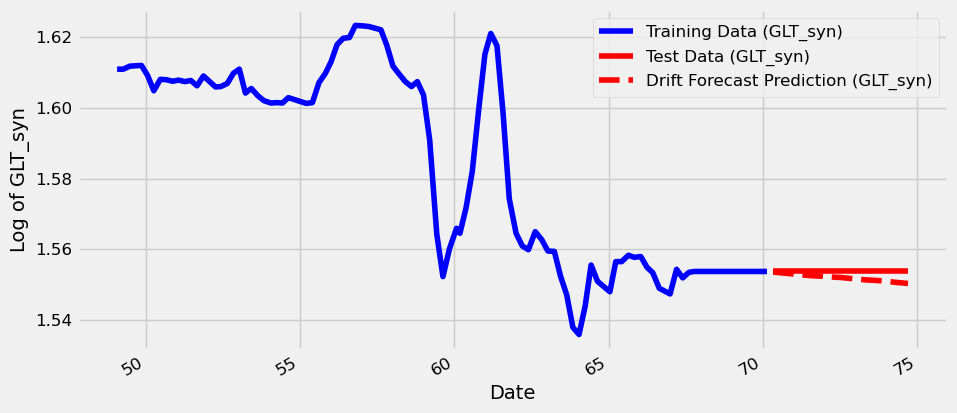

In [165]:
plt.figure(figsize=(10,5))


plt.plot(X_train["Age (Kyr ago)"][-100:],
            X_train.log_GLT_syn[-100:],
            'b-',
            label="Training Data (GLT_syn)")

plt.plot(Y_test["Age (Kyr ago)"],
            Y_test.log_GLT_syn,
            'r-',
            label="Test Data (GLT_syn)")

plt.plot(Y_test["Age (Kyr ago)"],
            drift_pred,
            'r--',
            label="Drift Forecast Prediction (GLT_syn)")

plt.legend(fontsize=12, loc=2)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of GLT_syn", fontsize=14)

plt.gcf().autofmt_xdate()
plt.legend(fontsize=12, loc=1)

plt.show()

In [167]:
beta_hat = (X_train["log_BIT index "].values[-1] - X_train["log_BIT index "].values[0])/len(X_train)
drift_pred = X_train["log_BIT index "].values[-1] + beta_hat*np.arange(1,len(Y_test) + 1)
sigma = np.sqrt(((X_train["log_BIT index "].diff() - beta_hat)**2).sum()/len(X_train))

In [169]:
df_reverse.columns

Index(['CO2 (ppmv) ', 'Rescaled MST (°C)', 'δ18O ', 'GLT_syn', 'd18O_benthic',
       'BIT index ', 'Age (Kyr ago)', 'log_RescaledMST', 'log_δ18O ',
       'log_GLT_syn', 'log_d18O_benthic', 'log_BIT index ', 'log_CO2 (ppmv)'],
      dtype='object')

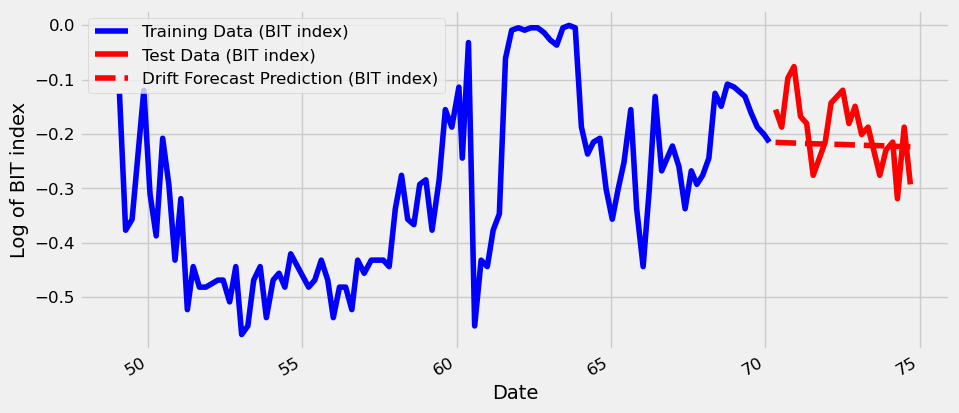

In [171]:
plt.figure(figsize=(10,5))


plt.plot(X_train["Age (Kyr ago)"][-100:],
            X_train["log_BIT index "][-100:],
            'b-',
            label="Training Data (BIT index)")

plt.plot(Y_test["Age (Kyr ago)"],
            Y_test["log_BIT index "],
            'r-',
            label="Test Data (BIT index)")

plt.plot(Y_test["Age (Kyr ago)"],
            drift_pred,
            'r--',
            label="Drift Forecast Prediction (BIT index)")

plt.legend(fontsize=12, loc=2)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of BIT index", fontsize=14)

plt.gcf().autofmt_xdate()
plt.legend(fontsize=12, loc=2)

plt.show()

In [174]:
beta_hat = (X_train["log_CO2 (ppmv)"].values[-1] - X_train["log_CO2 (ppmv)"].values[0])/len(X_train)
drift_pred = X_train["log_CO2 (ppmv)"].values[-1] + beta_hat*np.arange(1,len(Y_test) + 1)
sigma = np.sqrt(((X_train["log_CO2 (ppmv)"].diff() - beta_hat)**2).sum()/len(X_train))

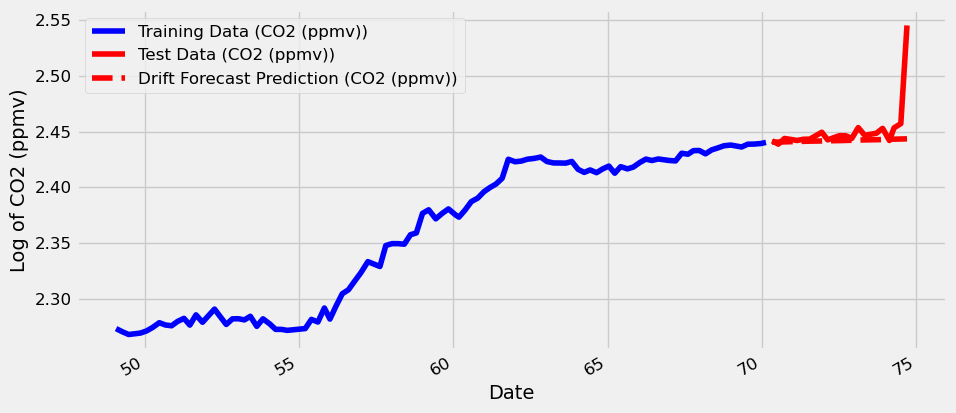

In [176]:
plt.figure(figsize=(10,5))


plt.plot(X_train["Age (Kyr ago)"][-100:],
            X_train["log_CO2 (ppmv)"][-100:],
            'b-',
            label="Training Data (CO2 (ppmv))")

plt.plot(Y_test["Age (Kyr ago)"],
            Y_test["log_CO2 (ppmv)"],
            'r-',
            label="Test Data (CO2 (ppmv))")

plt.plot(Y_test["Age (Kyr ago)"],
            drift_pred,
            'r--',
            label="Drift Forecast Prediction (CO2 (ppmv))")

plt.legend(fontsize=12, loc=2)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of CO2 (ppmv)", fontsize=14)

plt.gcf().autofmt_xdate()
plt.legend(fontsize=12, loc=2)

plt.show()